# Environment

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt
from pathlib import Path

import torch.nn.functional as F
from torchvision import models
from itertools import chain
from math import ceil

from sklearn.model_selection import train_test_split
from copy import deepcopy

from torchmetrics import JaccardIndex  # This is the same as MeanIoU


In [31]:
# Method 1: Basic cleanup
import torch
import gc

def cleanup():
    # Clear GPU cache
    torch.cuda.empty_cache()
    # Garbage collect
    gc.collect()

cleanup()

# Device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Hyperparameters

In [3]:
batch_size = 4
num_classes = 30  # Change as per your dataset
num_epochs = 50
learning_rate = 0.0001

# Color ID for different objects

In [4]:
id_map = {
    0: (0, 0, 0), # unlabelled
    1: (111, 74,  0), #static
    2: ( 81,  0, 81), #ground
    3: (128, 64,127), #road
    4: (244, 35,232), #sidewalk
    5: (250,170,160), #parking
    6: (230,150,140), #rail track
    7: (70, 70, 70), #building
    8: (102,102,156), #wall
    9: (190,153,153), #fence
    10: (180,165,180), #guard rail
    11: (150,100,100), #bridge
    12: (150,120, 90), #tunnel
    13: (153,153,153), #pole
    14: (153,153,153), #polegroup
    15: (250,170, 30), #traffic light
    16: (220,220,  0), #traffic sign
    17: (107,142, 35), #vegetation
    18: (152,251,152), #terrain
    19: ( 70,130,180), #sky
    20: (220, 20, 60), #person
    21: (255,  0,  0), #rider
    22: (  0,  0,142), #car
    23: (  0,  0, 70), #truck
    24: (  0, 60,100), #bus
    25: (  0,  0, 90), #caravan
    26: (  0,  0,110), #trailer
    27: (  0, 80,100), #train
    28: (  0,  0,230), #motorcycle
    29: (119, 11, 32), #bicycle
    30: (  0,  0,142) #license plate 
}

In [35]:
def preprocess_masks(image_dir, save_dir):
    """
    Preprocess all masks and save them as numpy arrays
    """
    # Create save directory if it doesn't exist
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    print("Preprocessing masks...")
    for img_file in tqdm(image_files):
        # Load image
        img_path = os.path.join(image_dir, img_file)
        img = Image.open(img_path)
        
        # Get mask portion (right half of image)
        mask_img = img.crop((256, 0, 512, 256)).resize((256, 256))
        mask_np = np.array(mask_img)
        
        # Create mask using vectorized operations
        h, w = mask_np.shape[:2]
        mask = np.zeros((h, w), dtype=np.int64)
        
        # Vectorized nearest neighbor search
        mask_flat = mask_np.reshape(-1, 3)
        colors = np.array(list(id_map.values()))
        distances = np.linalg.norm(mask_flat[:, np.newaxis] - colors, axis=2)
        nearest_class = np.argmin(distances, axis=1)
        mask = nearest_class.reshape(h, w)
        
        # Save preprocessed mask
        save_path = save_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        np.save(save_path, mask)

In [5]:
# Directories
image_dir = "../cityscapes_data/cityscapes_data/train"
mask_dir = "../cityscapes_data/cityscapes_data/mask"

# Preprocess masks (run once)
#preprocess_masks(image_dir, mask_dir)

# Dataloader

In [6]:
class CityscapeDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = Path(image_dir)
        self.mask_dir = Path(mask_dir)
        self.transform = transform
        
        # Get all image files
        self.image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_file = self.image_files[idx]
        img_path = self.image_dir / img_file
        img = Image.open(img_path)
        
        # Get input image (left half)
        img = img.crop((0, 0, 256, 256)).resize((512, 512))
        
        # Transform image
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.FloatTensor(np.array(img).transpose(2, 0, 1)) / 255.0
        
        # Load preprocessed mask
        mask_path = self.mask_dir / f"{os.path.splitext(img_file)[0]}_mask.npy"
        mask = np.load(mask_path)
        mask = torch.from_numpy(mask).unsqueeze(0)  # Add channel dimension
        
        return img, mask

# Create transform
transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], 
               std=[0.229, 0.224, 0.225])
])


In [7]:
def create_data_loaders(image_dir, mask_dir, batch_size, val_split=0.2):
    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]
    
    # Split into train and validation
    train_files, val_files = train_test_split(image_files, test_size=val_split, random_state=42)
    
    # Create custom datasets
    class CityscapeDatasetWithFiles(CityscapeDataset):
        def __init__(self, image_dir, mask_dir, file_list, transform=None):
            super().__init__(image_dir, mask_dir, transform)
            self.image_files = file_list
    
    # Create train and validation datasets
    train_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, train_files)
    val_dataset = CityscapeDatasetWithFiles(image_dir, mask_dir, val_files)
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader

In [39]:
# Create training and validation loaders
train_loader, val_loader = create_data_loaders(image_dir, mask_dir, batch_size)
len(train_loader)
len(val_loader)

149

# Refinenet architecture

In [8]:
from utils.helpers import maybe_download
from utils.layer_factory import conv1x1, conv3x3, CRPBlock, RCUBlock

data_info = {7: "Person", 21: "VOC", 40: "NYU", 60: "Context"}

models_urls = {
    "50_person": "https://cloudstor.aarnet.edu.au/plus/s/mLA7NxVSPjNL7Oo/download",
    "101_person": "https://cloudstor.aarnet.edu.au/plus/s/f1tGGpwdCnYS3xu/download",
    "152_person": "https://cloudstor.aarnet.edu.au/plus/s/Ql64rWqiTvWGAA0/download",
    "50_voc": "https://cloudstor.aarnet.edu.au/plus/s/xp7GcVKC0GbxhTv/download",
    "101_voc": "https://cloudstor.aarnet.edu.au/plus/s/CPRKWiaCIDRdOwF/download",
    "152_voc": "https://cloudstor.aarnet.edu.au/plus/s/2w8bFOd45JtPqbD/download",
    "50_nyu": "https://cloudstor.aarnet.edu.au/plus/s/gE8dnQmHr9svpfu/download",
    "101_nyu": "https://cloudstor.aarnet.edu.au/plus/s/VnsaSUHNZkuIqeB/download",
    "152_nyu": "https://cloudstor.aarnet.edu.au/plus/s/EkPQzB2KtrrDnKf/download",
    "101_context": "https://cloudstor.aarnet.edu.au/plus/s/hqmplxWOBbOYYjN/download",
    "152_context": "https://cloudstor.aarnet.edu.au/plus/s/O84NszlYlsu00fW/download",
    "50_imagenet": "https://download.pytorch.org/models/resnet50-19c8e357.pth",
    "101_imagenet": "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth",
    "152_imagenet": "https://download.pytorch.org/models/resnet152-b121ed2d.pth",
}

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class RefineNet(nn.Module):

    def __init__(self, block, layers, num_classes=21):
        self.inplanes = 64
        super(RefineNet, self).__init__()
        self.do = nn.Dropout(p=0.5)
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.p_ims1d2_outl1_dimred = conv3x3(2048, 512, bias=False)
        self.adapt_stage1_b = self._make_rcu(512, 512, 2, 2)
        self.mflow_conv_g1_pool = self._make_crp(512, 512, 4)
        self.mflow_conv_g1_b = self._make_rcu(512, 512, 3, 2)
        self.mflow_conv_g1_b3_joint_varout_dimred = conv3x3(512, 256, bias=False)
        self.p_ims1d2_outl2_dimred = conv3x3(1024, 256, bias=False)
        self.adapt_stage2_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage2_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g2_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g2_b = self._make_rcu(256, 256, 3, 2)
        self.mflow_conv_g2_b3_joint_varout_dimred = conv3x3(256, 256, bias=False)

        self.p_ims1d2_outl3_dimred = conv3x3(512, 256, bias=False)
        self.adapt_stage3_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage3_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g3_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g3_b = self._make_rcu(256, 256, 3, 2)
        self.mflow_conv_g3_b3_joint_varout_dimred = conv3x3(256, 256, bias=False)

        self.p_ims1d2_outl4_dimred = conv3x3(256, 256, bias=False)
        self.adapt_stage4_b = self._make_rcu(256, 256, 2, 2)
        self.adapt_stage4_b2_joint_varout_dimred = conv3x3(256, 256, bias=False)
        self.mflow_conv_g4_pool = self._make_crp(256, 256, 4)
        self.mflow_conv_g4_b = self._make_rcu(256, 256, 3, 2)

        self.clf_conv = nn.Conv2d(256, num_classes, kernel_size=3, stride=1,
                                  padding=1, bias=True)

    def _make_crp(self, in_planes, out_planes, stages):
        layers = [CRPBlock(in_planes, out_planes,stages)]
        return nn.Sequential(*layers)
    
    def _make_rcu(self, in_planes, out_planes, blocks, stages):
        layers = [RCUBlock(in_planes, out_planes, blocks, stages)]
        return nn.Sequential(*layers)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        l1 = self.layer1(x)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)
        l4 = self.layer4(l3)

        l4 = self.do(l4)
        l3 = self.do(l3)

        x4 = self.p_ims1d2_outl1_dimred(l4)
        x4 = self.relu(x4)
        x4 = self.mflow_conv_g1_pool(x4)
        x4 = self.mflow_conv_g1_b3_joint_varout_dimred(x4)
        x4 = nn.Upsample(size=l3.size()[2:], mode="bilinear", align_corners=True)(x4)

        x3 = self.p_ims1d2_outl2_dimred(l3)
        x3 = self.adapt_stage2_b2_joint_varout_dimred(x3)
        x3 = x3 + x4
        x3 = F.relu(x3)
        x3 = self.mflow_conv_g2_pool(x3)
        x3 = self.mflow_conv_g2_b3_joint_varout_dimred(x3)
        x3 = nn.Upsample(size=l2.size()[2:], mode="bilinear", align_corners=True)(x3)

        x2 = self.p_ims1d2_outl3_dimred(l2)
        x2 = self.adapt_stage3_b2_joint_varout_dimred(x2)
        x2 = x2 + x3
        x2 = F.relu(x2)
        x2 = self.mflow_conv_g3_pool(x2)
        x2 = self.mflow_conv_g3_b3_joint_varout_dimred(x2)
        x2 = nn.Upsample(size=l1.size()[2:], mode="bilinear", align_corners=True)(x2)

        x1 = self.p_ims1d2_outl4_dimred(l1)
        x1 = self.adapt_stage4_b2_joint_varout_dimred(x1)
        x1 = x1 + x2
        x1 = F.relu(x1)
        x1 = self.mflow_conv_g4_pool(x1)

        out = self.clf_conv(x1)
        # Add upsampling to match target size
        out = F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=True)
        
        return out


def rf101(num_classes, imagenet=False, pretrained=True, **kwargs):
    model = RefineNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, **kwargs)
    if imagenet:
        key = '101_imagenet'
        url = models_urls[key]
        model.load_state_dict(maybe_download(key, url), strict=False)
    elif pretrained:
        dataset = data_info.get(num_classes, None)
        if dataset:
            bname = '101_nyu'
            key = 'rf_lw' + bname
            url = models_urls[bname]
            model.load_state_dict(maybe_download(key, url), strict=False)
    return model

In [41]:
# Test block to print layer dimensions
def print_layer_dimensions(model, input_size=(1, 3, 256, 256)):
    """
    Print dimensions of each layer's output in RefineNet
    Args:
        model: The RefineNet model
        input_size: Tuple of (batch_size, channels, height, width)
    """
    print("\n=== RefineNet Layer Dimensions ===")
    
    # Set model to eval mode and move to device
    model.eval()
    
    # Create sample input
    x = torch.randn(input_size).to(device)
    
    with torch.no_grad():
        # Initial layers
        print("\nEncoder Path:")
        print(f"Input: {x.shape}")
        
        x = model.conv1(x)
        x = model.bn1(x)
        x = model.relu(x)
        print(f"After initial conv+bn+relu: {x.shape}")
        
        x = model.maxpool(x)
        print(f"After maxpool: {x.shape}")
        
        # Encoder path
        l1 = model.layer1(x)
        print(f"After layer1: {l1.shape}")
        
        l2 = model.layer2(l1)
        print(f"After layer2: {l2.shape}")
        
        l3 = model.layer3(l2)
        print(f"After layer3: {l3.shape}")
        
        l4 = model.layer4(l3)
        print(f"After layer4: {l4.shape}")
        
        # Decoder path
        print("\nDecoder Path:")
        l4 = model.do(l4)
        l3 = model.do(l3)
        
        x4 = model.p_ims1d2_outl1_dimred(l4)
        print(f"After p_ims1d2_outl1_dimred: {x4.shape}")
        
        x4 = model.adapt_stage1_b(x4)
        x4 = model.relu(x4)
        x4 = model.mflow_conv_g1_pool(x4)
        x4 = model.mflow_conv_g1_b(x4)
        x4 = model.mflow_conv_g1_b3_joint_varout_dimred(x4)
        print(f"After mflow_conv_g1: {x4.shape}")
        
        x4 = nn.Upsample(size=l3.size()[2:], mode='bilinear', align_corners=True)(x4)
        print(f"After upsample to l3 size: {x4.shape}")
        
        x3 = model.p_ims1d2_outl2_dimred(l3)
        x3 = model.adapt_stage2_b(x3)
        x3 = model.adapt_stage2_b2_joint_varout_dimred(x3)
        x3 = x3 + x4
        x3 = F.relu(x3)
        x3 = model.mflow_conv_g2_pool(x3)
        x3 = model.mflow_conv_g2_b(x3)
        x3 = model.mflow_conv_g2_b3_joint_varout_dimred(x3)
        print(f"After mflow_conv_g2: {x3.shape}")
        
        x3 = nn.Upsample(size=l2.size()[2:], mode='bilinear', align_corners=True)(x3)
        print(f"After upsample to l2 size: {x3.shape}")
        
        x2 = model.p_ims1d2_outl3_dimred(l2)
        x2 = model.adapt_stage3_b(x2)
        x2 = model.adapt_stage3_b2_joint_varout_dimred(x2)
        x2 = x2 + x3
        x2 = F.relu(x2)
        x2 = model.mflow_conv_g3_pool(x2)
        x2 = model.mflow_conv_g3_b(x2)
        x2 = model.mflow_conv_g3_b3_joint_varout_dimred(x2)
        print(f"After mflow_conv_g3: {x2.shape}")
        
        x2 = nn.Upsample(size=l1.size()[2:], mode='bilinear', align_corners=True)(x2)
        print(f"After upsample to l1 size: {x2.shape}")
        
        x1 = model.p_ims1d2_outl4_dimred(l1)
        x1 = model.adapt_stage4_b(x1)
        x1 = model.adapt_stage4_b2_joint_varout_dimred(x1)
        x1 = x1 + x2
        x1 = F.relu(x1)
        x1 = model.mflow_conv_g4_pool(x1)
        x1 = model.mflow_conv_g4_b(x1)
        x1 = model.do(x1)
        print(f"After final mflow_conv_g4: {x1.shape}")
        
        # Final classification
        out = model.clf_conv(x1)
        print(f"After classification conv: {out.shape}")
        
        out = F.interpolate(out, size=(256, 256), mode='bilinear', align_corners=True)
        print(f"Final output: {out.shape}")

# Test the dimensions
model = rf101(num_classes=num_classes).to(device)
print_layer_dimensions(model)


=== RefineNet Layer Dimensions ===

Encoder Path:
Input: torch.Size([1, 3, 256, 256])
After initial conv+bn+relu: torch.Size([1, 64, 128, 128])
After maxpool: torch.Size([1, 64, 64, 64])
After layer1: torch.Size([1, 256, 64, 64])
After layer2: torch.Size([1, 512, 32, 32])
After layer3: torch.Size([1, 1024, 16, 16])
After layer4: torch.Size([1, 2048, 8, 8])

Decoder Path:
After p_ims1d2_outl1_dimred: torch.Size([1, 512, 8, 8])
After mflow_conv_g1: torch.Size([1, 256, 8, 8])
After upsample to l3 size: torch.Size([1, 256, 16, 16])
After mflow_conv_g2: torch.Size([1, 256, 16, 16])
After upsample to l2 size: torch.Size([1, 256, 32, 32])
After mflow_conv_g3: torch.Size([1, 256, 32, 32])
After upsample to l1 size: torch.Size([1, 256, 64, 64])
After final mflow_conv_g4: torch.Size([1, 256, 64, 64])
After classification conv: torch.Size([1, 30, 64, 64])
Final output: torch.Size([1, 30, 256, 256])


# Training main code

In [42]:
class EarlyStopping:
    def __init__(self, patience=7, min_delta=0, verbose=True, min_epochs=10):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
        self.min_epochs = min_epochs
        self.epoch_counter = 0
    
    def __call__(self, val_loss, model):
        self.epoch_counter += 1
        
        # Don't start early stopping until minimum epochs are reached
        if self.epoch_counter < self.min_epochs:
            if self.best_loss is None or val_loss < self.best_loss:
                self.best_loss = val_loss
                self.best_model = deepcopy(model.state_dict())
            return
        
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model = deepcopy(model.state_dict())
            self.counter = 0

  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  9 12 15 16 17 18 19 20 21 22 23 24 26 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


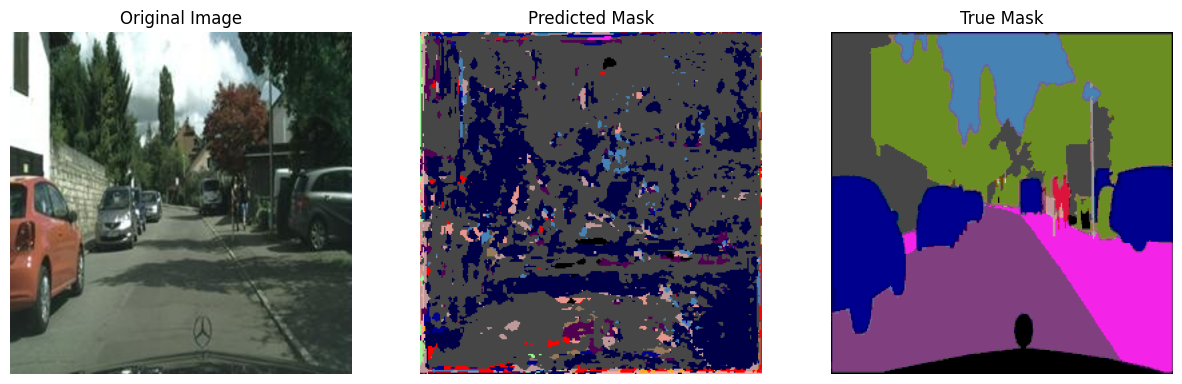

Validation: 100%|██████████| 149/149 [00:27<00:00,  5.51it/s]



Epoch [1/50]
Training Loss: 1.1357, Training mIoU: 0.1452
Validation Loss: 0.9117, Validation mIoU: 0.1752


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


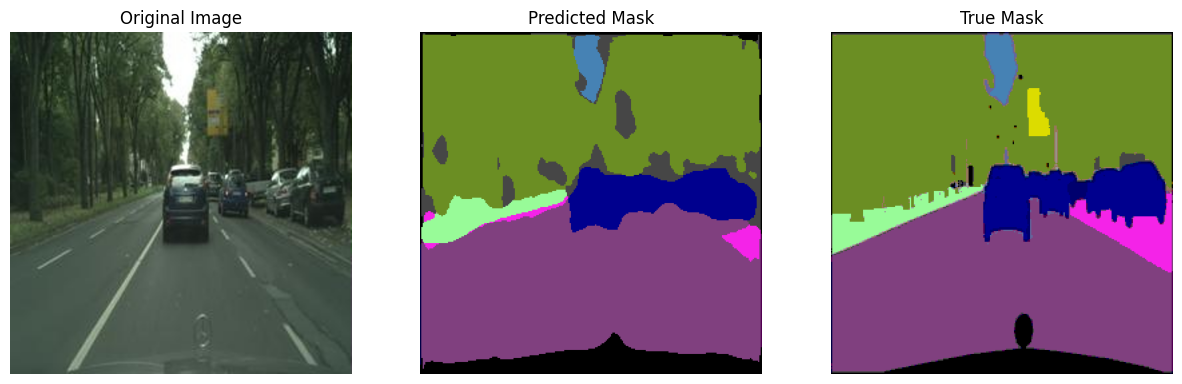

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.61it/s]



Epoch [2/50]
Training Loss: 0.8674, Training mIoU: 0.1928
Validation Loss: 0.8552, Validation mIoU: 0.1965


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 16 17 18 19 20 22 23 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


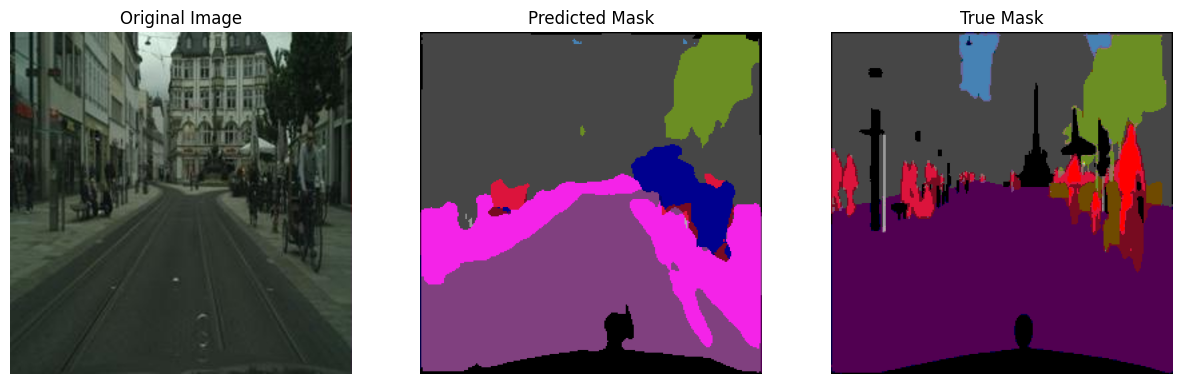

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.80it/s]



Epoch [3/50]
Training Loss: 0.7861, Training mIoU: 0.2122
Validation Loss: 0.9121, Validation mIoU: 0.1988


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 12 16 17 18 19 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


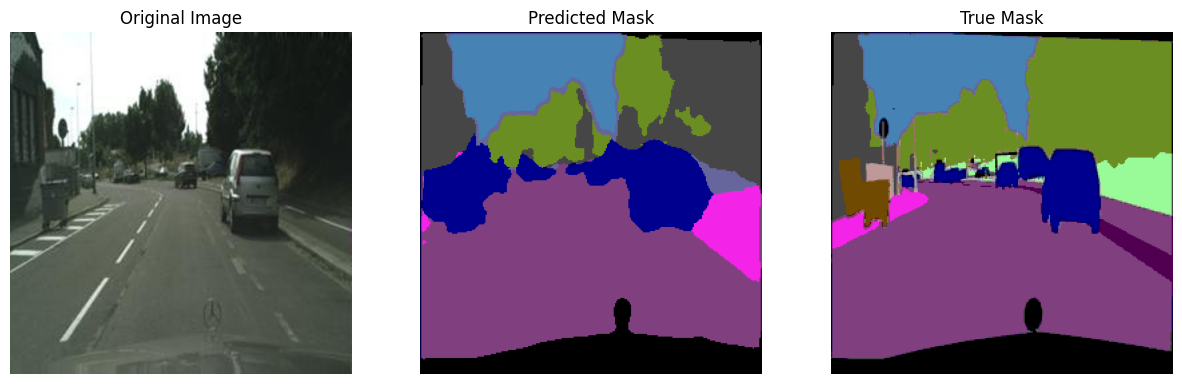

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.88it/s]



Epoch [4/50]
Training Loss: 0.7296, Training mIoU: 0.2257
Validation Loss: 0.7596, Validation mIoU: 0.2220


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 11 13 15 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


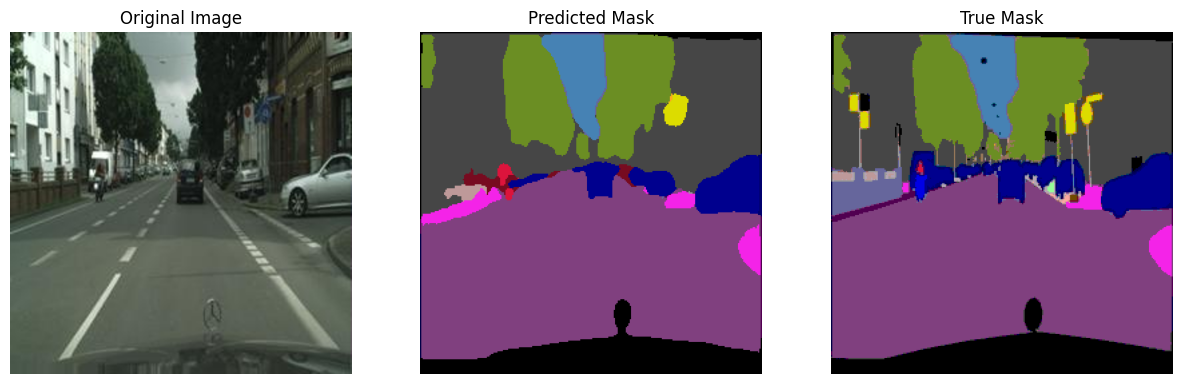

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.87it/s]



Epoch [5/50]
Training Loss: 0.6964, Training mIoU: 0.2347
Validation Loss: 0.6738, Validation mIoU: 0.2351


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 25 26 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


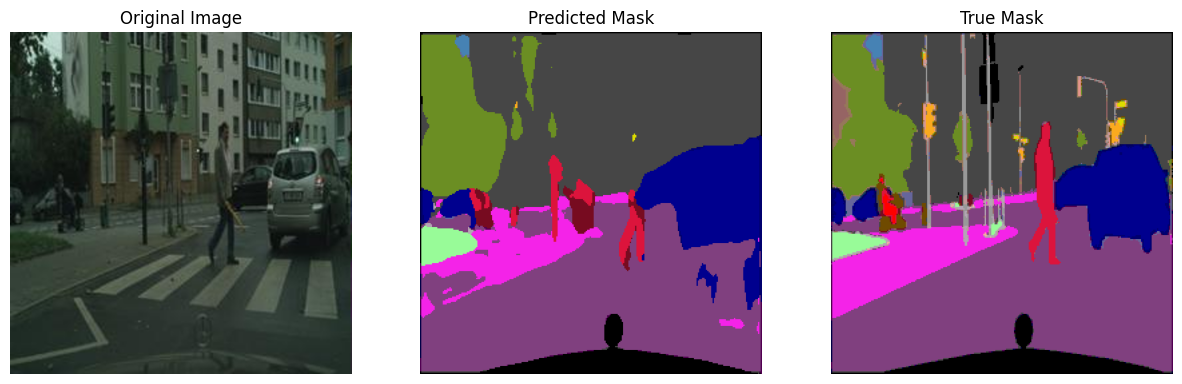

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.60it/s]



Epoch [6/50]
Training Loss: 0.6664, Training mIoU: 0.2438
Validation Loss: 0.6897, Validation mIoU: 0.2411


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


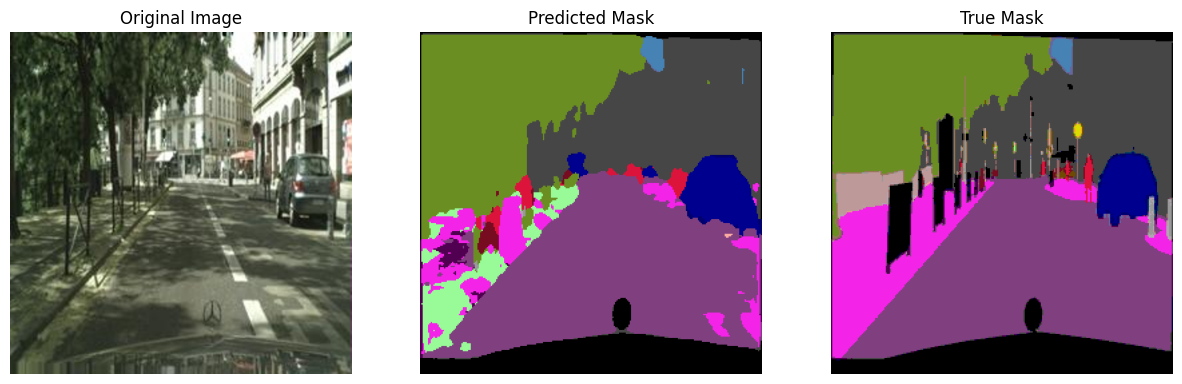

Validation: 100%|██████████| 149/149 [00:23<00:00,  6.47it/s]



Epoch [7/50]
Training Loss: 0.6449, Training mIoU: 0.2486
Validation Loss: 0.6457, Validation mIoU: 0.2516


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 12 13 16 17 18 19 20 22 23 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


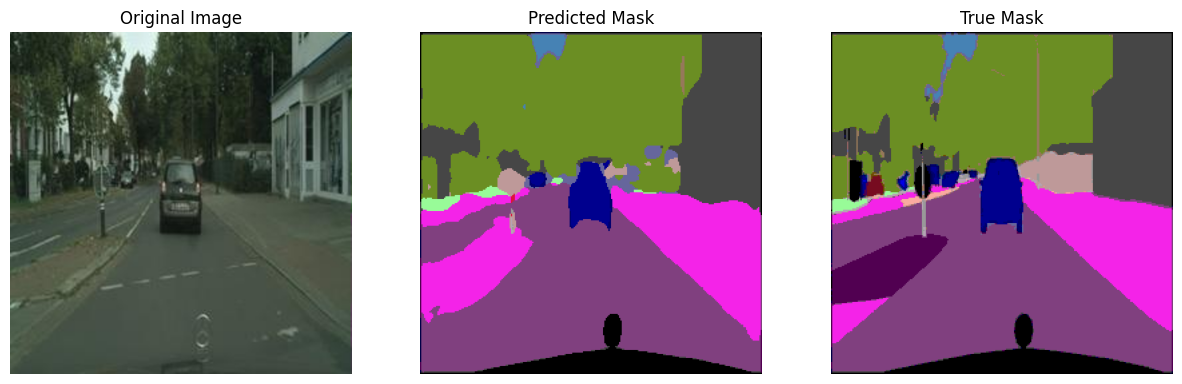

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.84it/s]



Epoch [8/50]
Training Loss: 0.6272, Training mIoU: 0.2552
Validation Loss: 0.6757, Validation mIoU: 0.2379


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  7  8  9 10 11 12 13 16 17 18 19 20 22 23 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


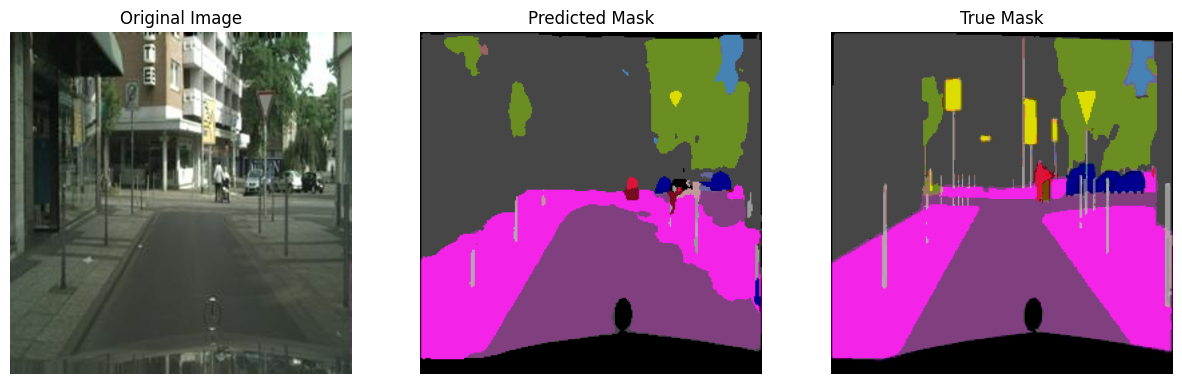

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.80it/s]



Epoch [9/50]
Training Loss: 0.6070, Training mIoU: 0.2613
Validation Loss: 0.6258, Validation mIoU: 0.2576


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


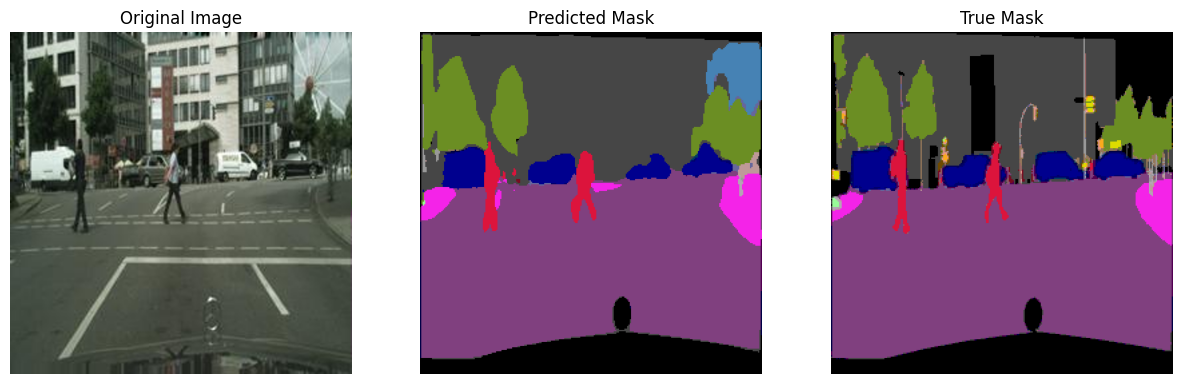

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.70it/s]



Epoch [10/50]
Training Loss: 0.5912, Training mIoU: 0.2667
Validation Loss: 0.6335, Validation mIoU: 0.2647
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 25 26 27
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


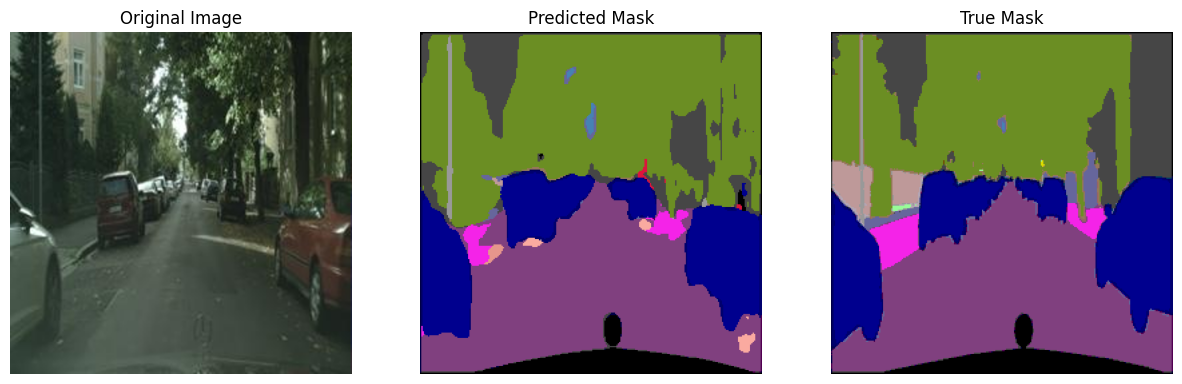

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.85it/s]



Epoch [11/50]
Training Loss: 0.5847, Training mIoU: 0.2692
Validation Loss: 0.6044, Validation mIoU: 0.2584


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


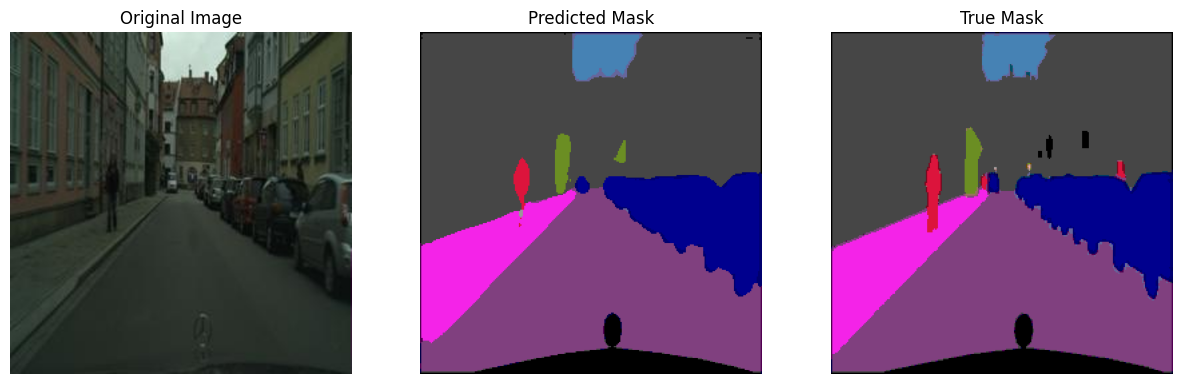

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.73it/s]



Epoch [12/50]
Training Loss: 0.5706, Training mIoU: 0.2741
Validation Loss: 0.6175, Validation mIoU: 0.2615
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 12 13 16 17 18 19 20 22 23 24 25 26 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


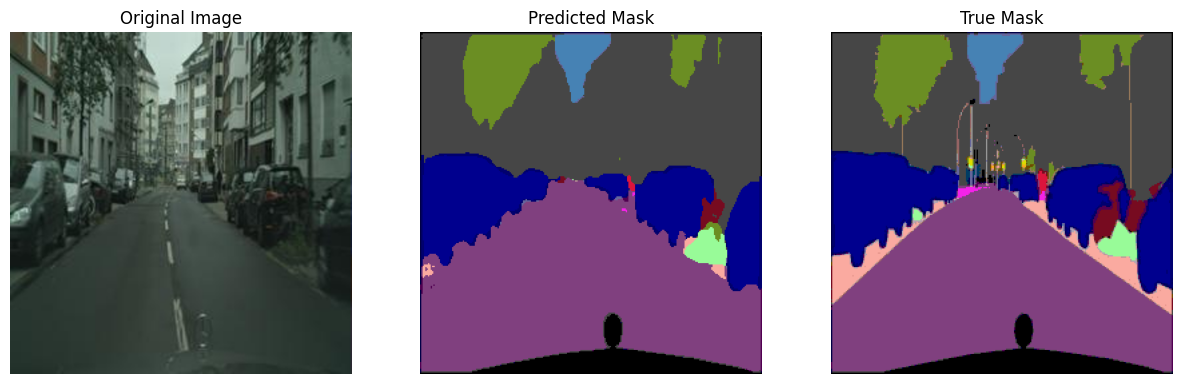

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.65it/s]



Epoch [13/50]
Training Loss: 0.5538, Training mIoU: 0.2790
Validation Loss: 0.5992, Validation mIoU: 0.2763


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


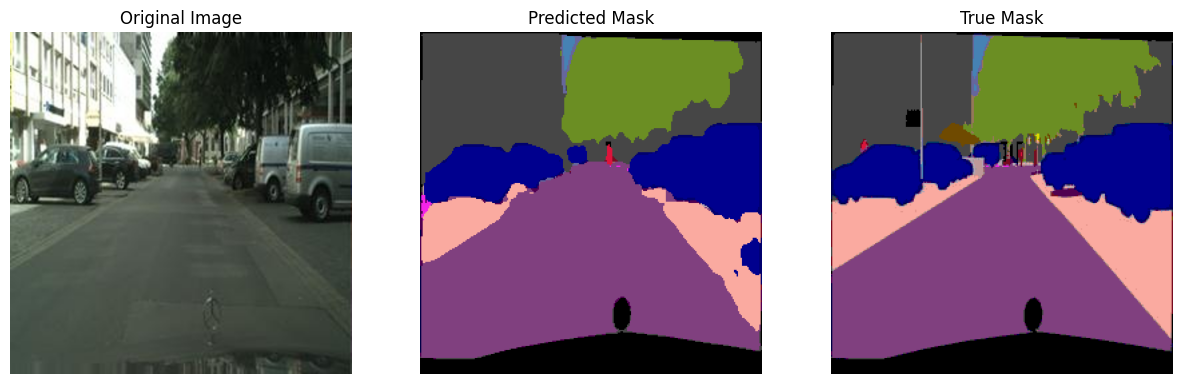

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.84it/s]



Epoch [14/50]
Training Loss: 0.5380, Training mIoU: 0.2850
Validation Loss: 0.5969, Validation mIoU: 0.2707
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


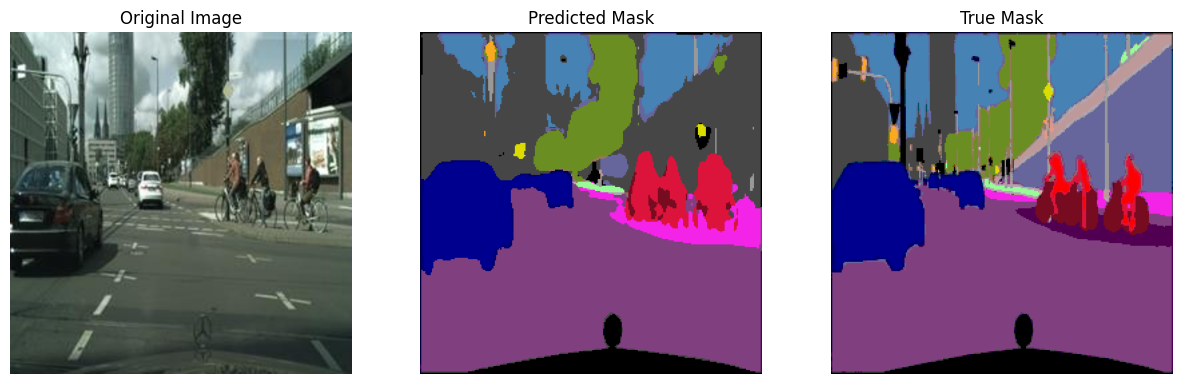

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.57it/s]



Epoch [15/50]
Training Loss: 0.5307, Training mIoU: 0.2868
Validation Loss: 0.5640, Validation mIoU: 0.2811


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


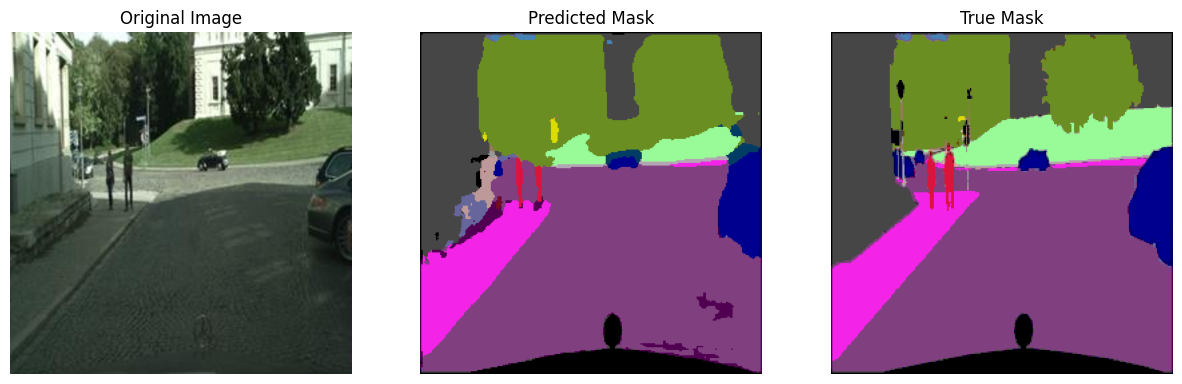

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.69it/s]



Epoch [16/50]
Training Loss: 0.5217, Training mIoU: 0.2911
Validation Loss: 0.6116, Validation mIoU: 0.2704
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


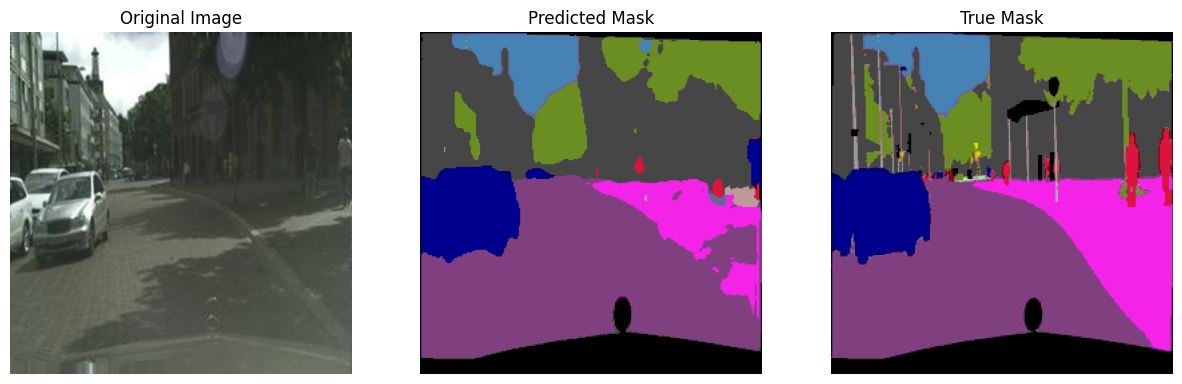

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.50it/s]



Epoch [17/50]
Training Loss: 0.5109, Training mIoU: 0.2959
Validation Loss: 0.5682, Validation mIoU: 0.2812
EarlyStopping counter: 2 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 12 13 15 16 17 18 19 20 21 22 23 26 28
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


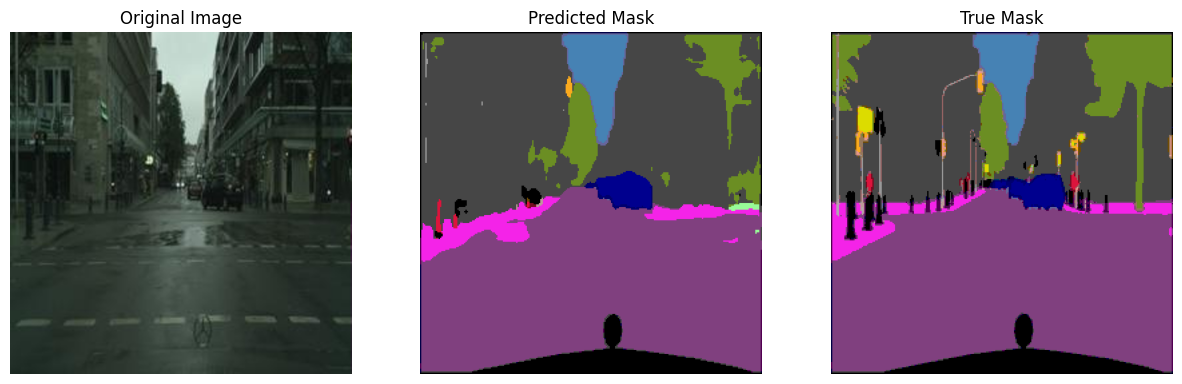

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.70it/s]



Epoch [18/50]
Training Loss: 0.5061, Training mIoU: 0.2971
Validation Loss: 0.5902, Validation mIoU: 0.2748
EarlyStopping counter: 3 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


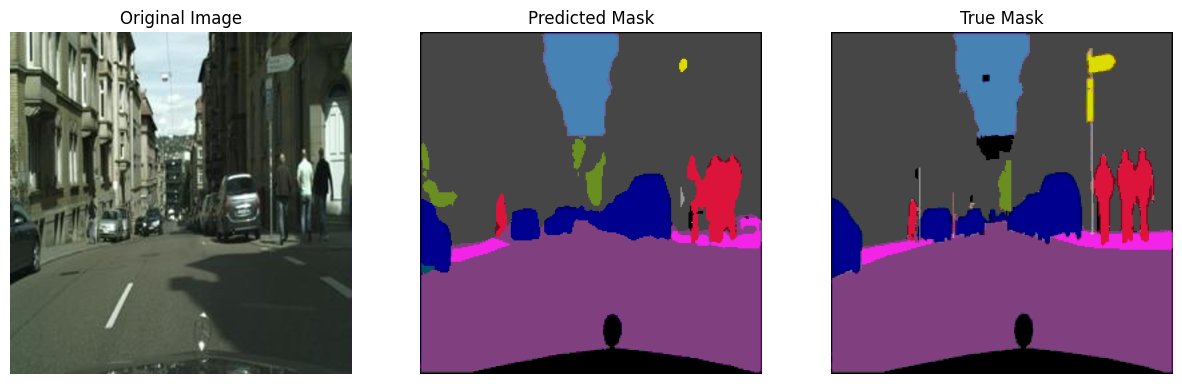

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.53it/s]



Epoch [19/50]
Training Loss: 0.4879, Training mIoU: 0.3045
Validation Loss: 0.5515, Validation mIoU: 0.2922


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


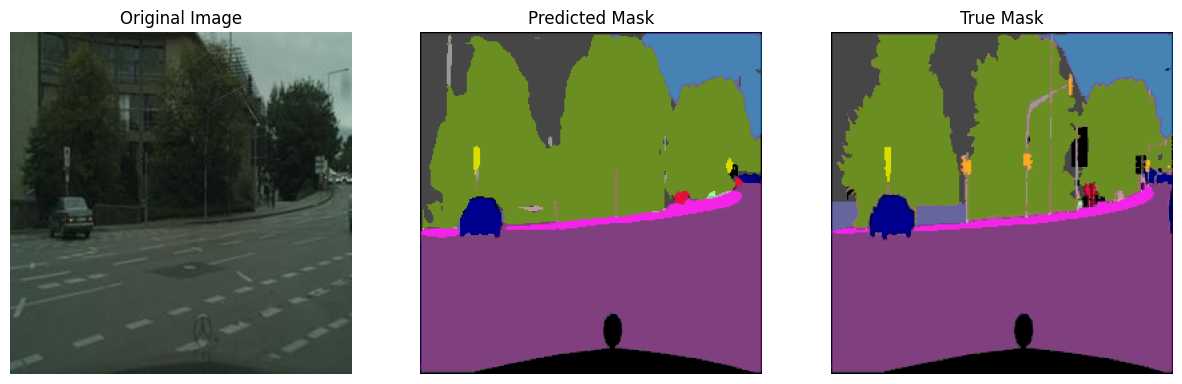

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.93it/s]



Epoch [20/50]
Training Loss: 0.4829, Training mIoU: 0.3076
Validation Loss: 0.5763, Validation mIoU: 0.2811
EarlyStopping counter: 1 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  2  3  4  6  7  8  9 10 12 13 15 16 17 18 19 20 22 23 24 25 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


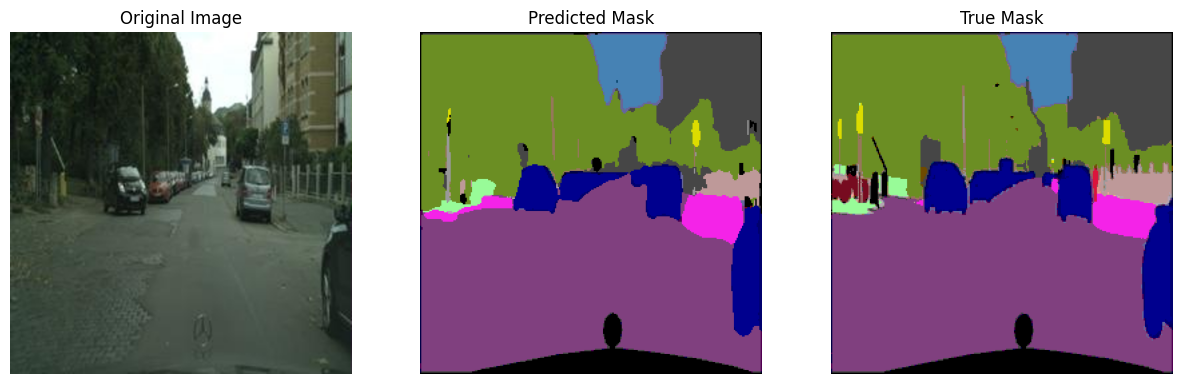

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.69it/s]



Epoch [21/50]
Training Loss: 0.4767, Training mIoU: 0.3093
Validation Loss: 0.5637, Validation mIoU: 0.2917
EarlyStopping counter: 2 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]


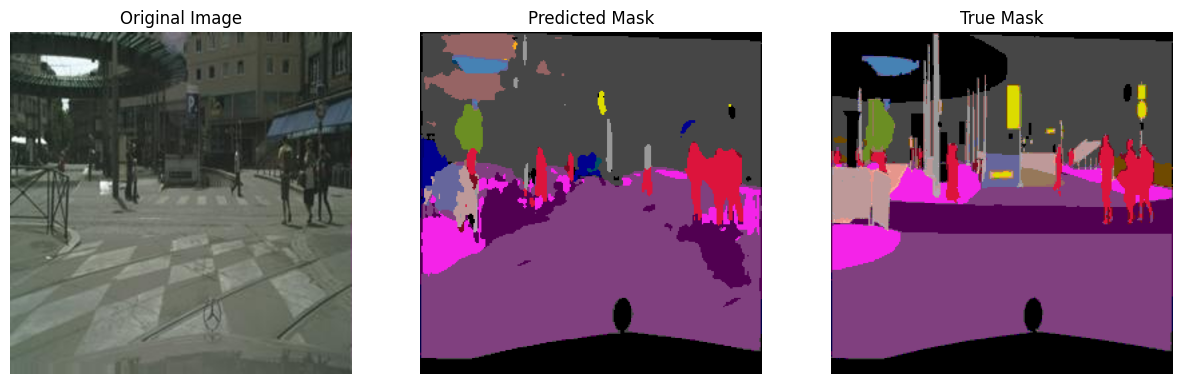

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.91it/s]



Epoch [22/50]
Training Loss: 0.4635, Training mIoU: 0.3145
Validation Loss: 0.5618, Validation mIoU: 0.2940
EarlyStopping counter: 3 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25
 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


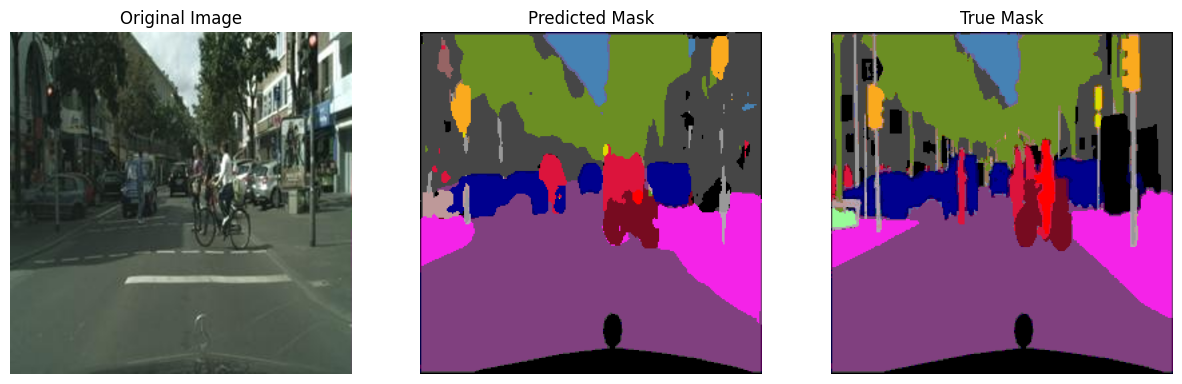

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.84it/s]



Epoch [23/50]
Training Loss: 0.4584, Training mIoU: 0.3160
Validation Loss: 0.6580, Validation mIoU: 0.2767
EarlyStopping counter: 4 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


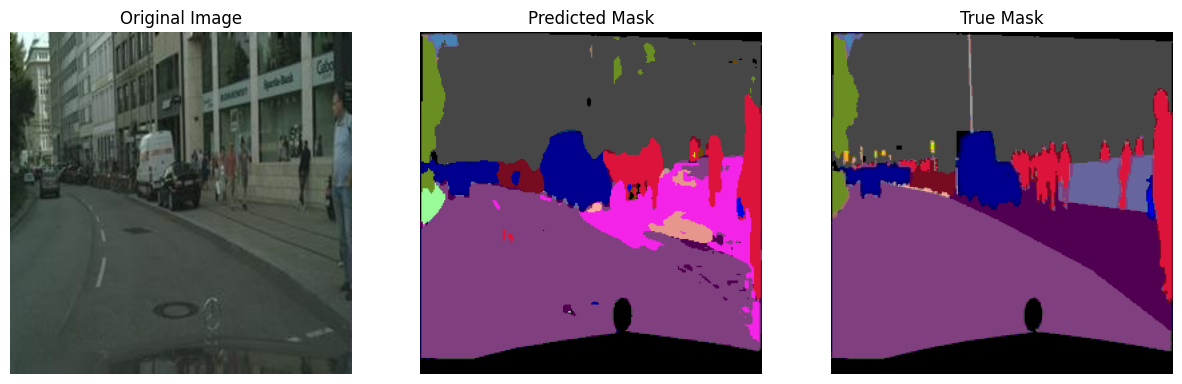

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.60it/s]



Epoch [24/50]
Training Loss: 0.4658, Training mIoU: 0.3152
Validation Loss: 0.5630, Validation mIoU: 0.2886
EarlyStopping counter: 5 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


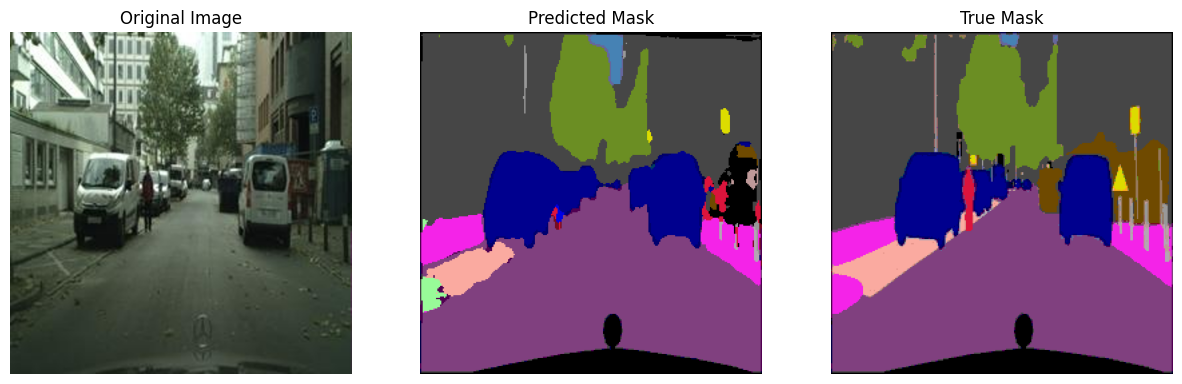

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.76it/s]



Epoch [25/50]
Training Loss: 0.4315, Training mIoU: 0.3285
Validation Loss: 0.6038, Validation mIoU: 0.2926
EarlyStopping counter: 6 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]


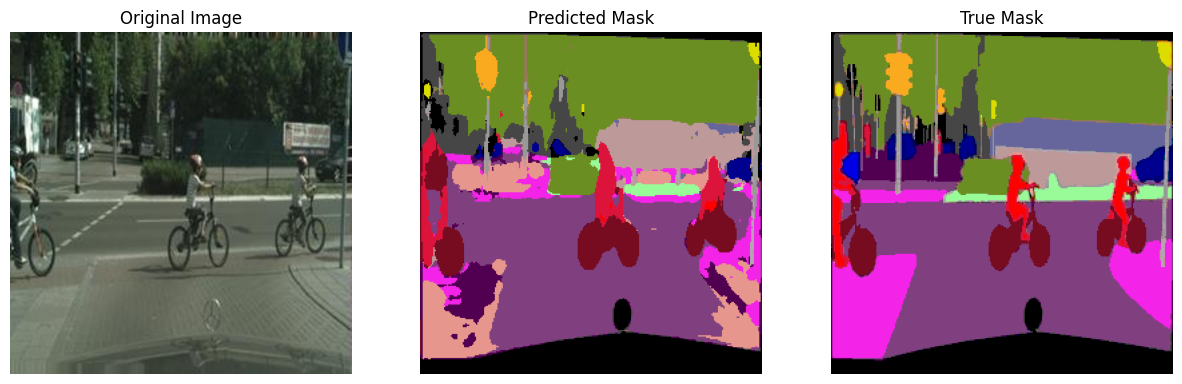

Validation: 100%|██████████| 149/149 [00:22<00:00,  6.66it/s]



Epoch [26/50]
Training Loss: 0.4313, Training mIoU: 0.3288
Validation Loss: 0.5760, Validation mIoU: 0.2882
EarlyStopping counter: 7 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


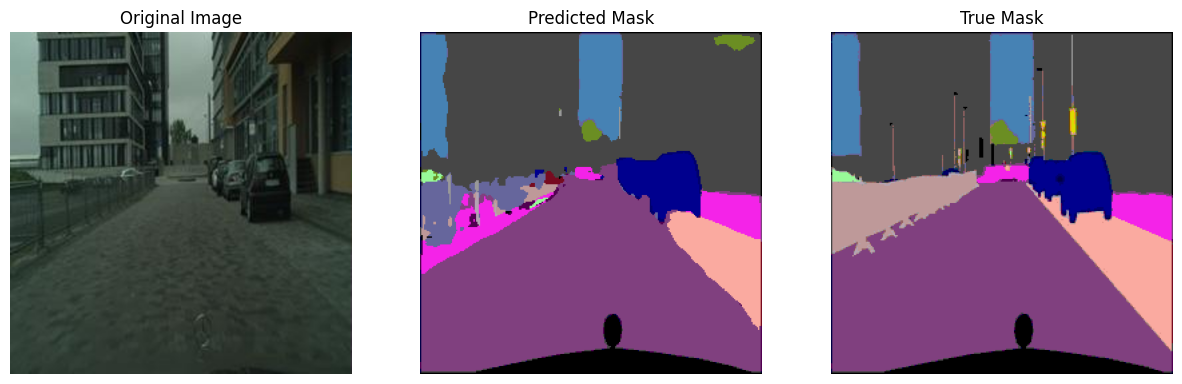

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.81it/s]



Epoch [27/50]
Training Loss: 0.4306, Training mIoU: 0.3294
Validation Loss: 0.5758, Validation mIoU: 0.3012
EarlyStopping counter: 8 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25 26
 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


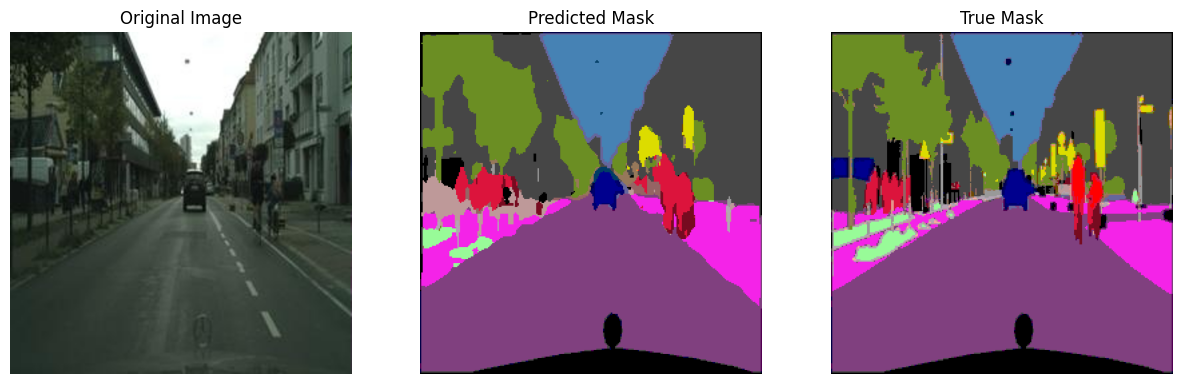

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.85it/s]



Epoch [28/50]
Training Loss: 0.4238, Training mIoU: 0.3321
Validation Loss: 0.5614, Validation mIoU: 0.3018
EarlyStopping counter: 9 out of 10


  0%|          | 0/595 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 28 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24
 25 26 27 29]


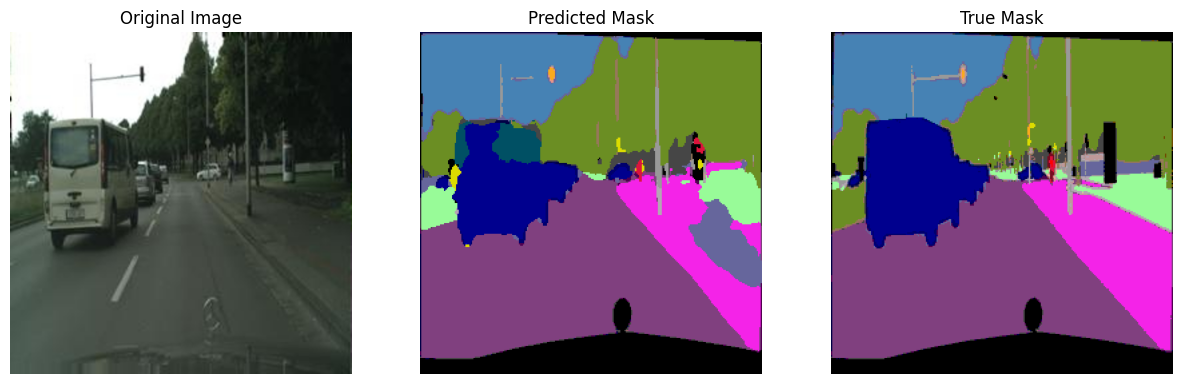

Validation: 100%|██████████| 149/149 [00:21<00:00,  6.90it/s]


Epoch [29/50]
Training Loss: 0.4185, Training mIoU: 0.3353
Validation Loss: 0.5680, Validation mIoU: 0.3064
EarlyStopping counter: 10 out of 10
Early stopping triggered
Training finished!


In [43]:
# Initialize model, loss function, and optimizer
model = rf101(num_classes=num_classes, imagenet=False, pretrained=True).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
early_stopping = EarlyStopping(patience=10, min_delta=0.005, verbose=True, min_epochs=10)

# Add these lists before the training loop to store metrics
train_losses = []
val_losses = []
train_mious = []
val_mious = []

# Initialize the IoU metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Training loop
for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    train_batch_mious = []
    batch_idx = 0
    # Use tqdm for progress bar
    for (images, masks) in tqdm(train_loader):
        # Move data to device
        images = images.float().to(device)
        # Remove the channel dimension (squeeze) from masks
        masks = masks.squeeze(1).long().to(device)  # Changed from squeeze(3) to squeeze(1)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)
        
        # Calculate loss
        loss = criterion(outputs, masks)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()

        # Print loss every 10 batches
        #if (batch_idx + 1) % 10 == 0:
        #    print(f'Batch [{batch_idx+1}/{len(dataloader)}] Loss: {loss.item():.4f}')
        
        # Print predictions for the first batch of each epoch
        
         # Calculate training mIoU
        with torch.no_grad():
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            train_batch_mious.append(batch_miou.item())

        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1
    
    # Validation phase
    model.eval()
    val_loss = 0.0
    val_batch_mious = []

    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc='Validation'):
            images = images.float().to(device)
            masks = masks.squeeze(1).long().to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            # Calculate validation mIoU
            preds = torch.argmax(outputs, dim=1)
            batch_miou = jaccard(preds, masks)
            val_batch_mious.append(batch_miou.item())


    # Print average loss for the epoch
    # Calculate epoch metrics
    epoch_train_loss = running_loss / len(train_loader)
    epoch_val_loss = val_loss / len(val_loader)
    epoch_train_miou = np.mean(train_batch_mious)
    epoch_val_miou = np.mean(val_batch_mious)

    # Store metrics
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    train_mious.append(epoch_train_miou)
    val_mious.append(epoch_val_miou)

     # Print metrics
    print(f'\nEpoch [{epoch+1}/{num_epochs}]')
    print(f'Training Loss: {epoch_train_loss:.4f}, Training mIoU: {epoch_train_miou:.4f}')
    print(f'Validation Loss: {epoch_val_loss:.4f}, Validation mIoU: {epoch_val_miou:.4f}')

    # Early stopping
    early_stopping(epoch_val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered")
        model.load_state_dict(early_stopping.best_model)
        break

print('Training finished!')

# Plotting

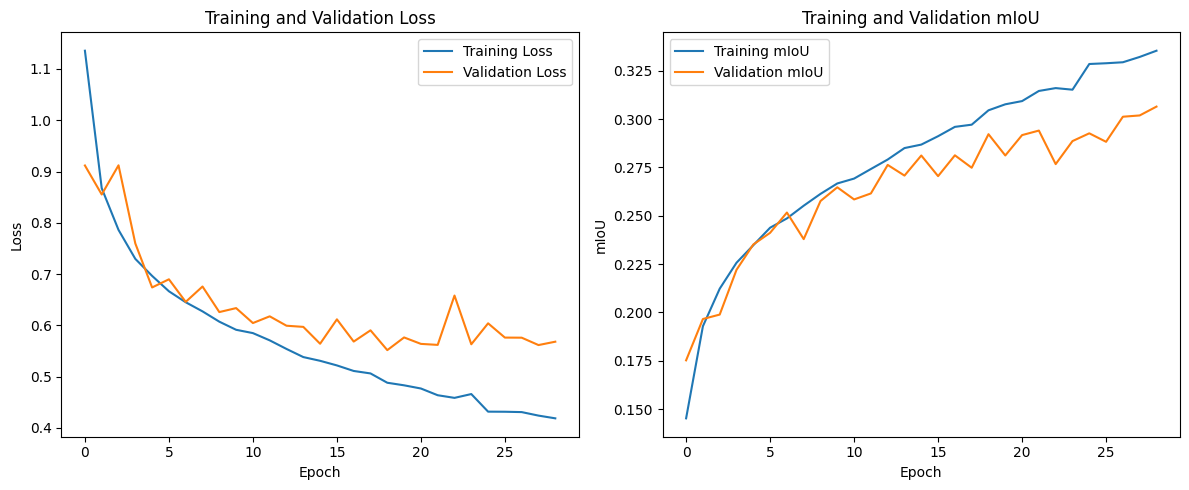

In [44]:
# Plot training curves
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# mIoU curve
plt.subplot(1, 2, 2)
plt.plot(train_mious, label='Training mIoU')
plt.plot(val_mious, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('Training and Validation mIoU')
plt.legend()

plt.tight_layout()
plt.show()

In [45]:
def save_model_as_npy(model, filepath):
    model_weights = model.state_dict()
    model_weights_dict = {k: v.cpu().numpy() for k, v in model_weights.items()}
    np.save(filepath, model_weights_dict)

In [46]:
save_model_as_npy(model, 'best_RefineNet_weight.npy')

# Testing

Load weights successfully.


Testing:   0%|          | 0/125 [00:00<?, ?it/s]


Predicted mask shape: (4, 256, 256)
True mask shape: (4, 256, 256)
Unique values in prediction: [ 0  1  2  3  4  7  8  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 25 26
 27 29]
Unique values in true mask: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 15 16 17 18 19 20 22 23 24 25
 26 27 29]


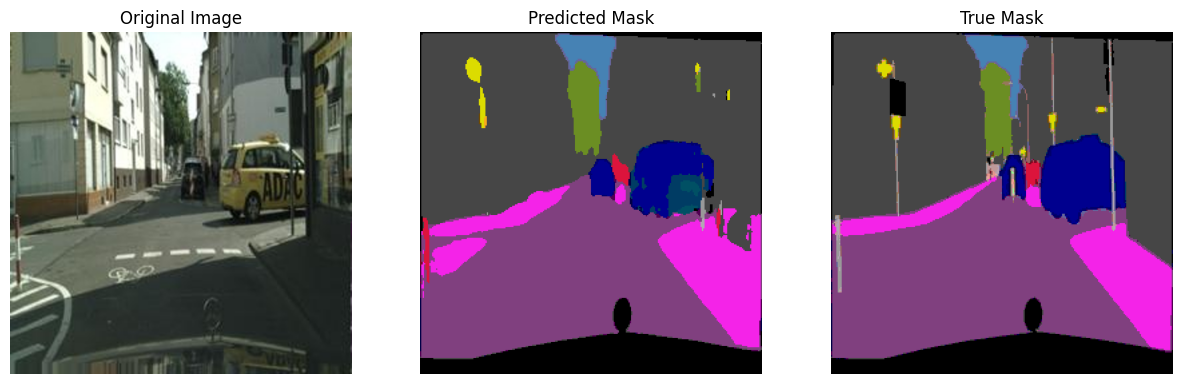

Testing: 100%|██████████| 125/125 [00:29<00:00,  4.30it/s]


Mean IoU: 0.2643
Mean Pixel Accuracy: 0.8316


Per-class IoU:   0%|          | 0/125 [00:00<?, ?it/s]


Mean IoU (excluding zeros): 0.3093
Mean IoU (including zeros): 0.2371
Mean Pixel Accuracy: 0.8316

IoU per class:
Class 0: 0.8443
Class 1: 0.0669
Class 2: 0.1954
Class 3: 0.8058
Class 4: 0.5163
Class 5: 0.0000
Class 6: 0.0000
Class 7: 0.7124
Class 8: 0.2457
Class 9: 0.0232
Class 10: 0.1470
Class 11: 0.0000
Class 12: 0.0083
Class 13: 0.0366
Class 14: 0.0000
Class 15: 0.0474
Class 16: 0.1837
Class 17: 0.7914
Class 18: 0.0098
Class 19: 0.8448
Class 20: 0.3570
Class 21: 0.0000
Class 22: 0.4823
Class 23: 0.2924
Class 24: 0.1034
Class 25: 0.0246
Class 26: 0.1636
Class 27: 0.0000
Class 28: 0.0000
Class 29: 0.2115

Number of classes with non-zero IoU: 23
Number of classes with zero IoU: 7


In [9]:
# Evaluate model (dummy example, replace with actual evaluation loop)
model = rf101(num_classes=num_classes, imagenet=False, pretrained=True).to(device)
weights = np.load('best_RefineNet_weight.npy', allow_pickle=True).item()

# Convert numpy arrays to torch tensors
state_dict = {k: torch.from_numpy(v) for k, v in weights.items()}
model.load_state_dict(state_dict)
print("Load weights successfully.")
model.eval()

image_dir = "../cityscapes_data/cityscapes_data/val"
mask_dir = "../cityscapes_data/cityscapes_data/val_mask"

dataset = CityscapeDataset(
        image_dir=image_dir,
        mask_dir=mask_dir
    )
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False
)

# Initialize the metric
jaccard = JaccardIndex(task="multiclass", num_classes=num_classes).to(device)

# Testing loop
model.eval()
miou_scores = []
pixel_accuracies = []


batch_idx = 0
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Testing'):
        # Move data to device
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)  # Remove channel dimension
        
        # Forward pass
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        # Calculate IoU
        batch_iou = jaccard(preds, masks)
        miou_scores.append(batch_iou.item())

         # Calculate pixel-wise accuracy
        correct_pixels = (preds == masks).sum().item()
        total_pixels = masks.numel()
        pixel_accuracy = correct_pixels / total_pixels
        pixel_accuracies.append(pixel_accuracy)

        # Print predictions for the first batch of each epoch
        if batch_idx == 0:
            with torch.no_grad():
                # Get predictions
                pred_masks = torch.argmax(outputs, dim=1)
                
                # Convert tensors to numpy for visualization
                pred_masks = pred_masks.cpu().numpy()
                true_masks = masks.cpu().numpy()
                
                # Print shapes and unique values for debugging
                print(f"\nPredicted mask shape: {pred_masks.shape}")
                print(f"True mask shape: {true_masks.shape}")
                print(f"Unique values in prediction: {np.unique(pred_masks)}")
                print(f"Unique values in true mask: {np.unique(true_masks)}")
                
                # Convert predictions and true masks to RGB using id_map
                pred_rgb = np.zeros((pred_masks.shape[0], pred_masks.shape[1], pred_masks.shape[2], 3))
                true_rgb = np.zeros((true_masks.shape[0], true_masks.shape[1], true_masks.shape[2], 3))
                
                for i in range(pred_masks.shape[0]):
                    for key, value in id_map.items():
                        pred_rgb[i][pred_masks[i] == key] = value
                        true_rgb[i][true_masks[i] == key] = value
                
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.imshow(images[0].cpu().permute(1,2,0))
                plt.title('Original Image')
                plt.axis('off')
                
                plt.subplot(132)
                plt.imshow(pred_rgb[0].astype(np.uint8))
                plt.title('Predicted Mask')
                plt.axis('off')
                
                plt.subplot(133)
                plt.imshow(true_rgb[0].astype(np.uint8))
                plt.title('True Mask')
                plt.axis('off')
                
                plt.show()
        batch_idx = batch_idx + 1

# Calculate and print mean IoU and pixel-wise accuracy
mean_iou = np.mean(miou_scores)
mean_pixel_accuracy = np.mean(pixel_accuracies)
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

# Calculate per-class IoU
class_iou = JaccardIndex(task="multiclass", num_classes=num_classes, average=None).to(device)
with torch.no_grad():
    for images, masks in tqdm(dataloader, desc='Per-class IoU'):
        images = images.float().to(device)
        masks = masks.squeeze(1).long().to(device)
        
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        
        iou_per_class = class_iou(preds, masks)
        break  # Just for one batch as example

# Move tensor to CPU and convert to numpy for calculations
iou_per_class = iou_per_class.cpu().numpy()

# Calculate mean IoU excluding zeros
non_zero_ious = [iou for iou in iou_per_class if iou > 0]
mean_iou_no_zeros = np.mean(non_zero_ious) if non_zero_ious else 0
mean_pixel_accuracy = np.mean(pixel_accuracies)

print(f"\nMean IoU (excluding zeros): {mean_iou_no_zeros:.4f}")
print(f"Mean IoU (including zeros): {np.mean(iou_per_class):.4f}")
print(f"Mean Pixel Accuracy: {mean_pixel_accuracy:.4f}")

print("\nIoU per class:")
for class_id, iou in enumerate(iou_per_class):
    print(f"Class {class_id}: {iou:.4f}")

print(f"\nNumber of classes with non-zero IoU: {len(non_zero_ious)}")
print(f"Number of classes with zero IoU: {len(iou_per_class) - len(non_zero_ious)}")

# FLOPs

In [10]:
from calflops import calculate_flops

# Define a dummy input tensor with the same shape as your input images
dummy_input = (1, 3, 256, 256)  # Adjust the size if your input size is different

# Initialize your model
model = rf101(num_classes=num_classes).to(device)

flops, macs, params = calculate_flops(model=model, 
                                      input_shape=dummy_input,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  99.08 M 
fwd MACs:                                                               27.7422 GMACs
fwd FLOPs:                                                              55.5342 GFLOPS
fwd+bwd MACs:                                                           83.2265 GMACs
fwd+bwd FLOPs:                                                          166.603 GFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mo

In [ ]:
# Import required libraries
from torchviz import make_dot
from torch.autograd import Variable

def visualize_model_architecture(model):
    # Create sample input matching RefineNet's expected input shape (B, C, H, W)
    x = Variable(torch.randn(1, 3, 256, 256)).to(device)
    
    # Get model output
    y = model(x)
    
    # Create dot graph
    dot = make_dot(y, params=dict(model.named_parameters()))
    
    # Customize graph appearance
    dot.attr(rankdir='TB')  # Top to bottom layout
    dot.attr('node', shape='box')
    
    # Save visualization
    dot.render('refinenet_architecture', format='png', cleanup=True)
    
    print("Model architecture visualization has been saved as 'refinenet_architecture.png'")

# Visualize model
model = rf101(num_classes=num_classes).to(device)
visualize_model_architecture(model)

Model architecture visualization has been saved as 'refinenet_architecture.png'


In [74]:
def count_parameters(model):
    """
    Count the total number of trainable parameters in the model
    """
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    # Convert to millions for better readability
    total_params_m = total_params / 1e6
    
    print(f'\nTotal Trainable Parameters: {total_params:,}')
    print(f'Total Trainable Parameters (M): {total_params_m:.2f}M')
    
    # Optional: Print parameters by layer
    print('\nParameters by layer:')
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f'{name}: {param.numel():,}')

# Call the function
model = rf101(num_classes=num_classes).to(device)
count_parameters(model)


Total Trainable Parameters: 99,081,054
Total Trainable Parameters (M): 99.08M

Parameters by layer:
conv1.weight: 9,408
bn1.weight: 64
bn1.bias: 64
layer1.0.conv1.weight: 4,096
layer1.0.bn1.weight: 64
layer1.0.bn1.bias: 64
layer1.0.conv2.weight: 36,864
layer1.0.bn2.weight: 64
layer1.0.bn2.bias: 64
layer1.0.conv3.weight: 16,384
layer1.0.bn3.weight: 256
layer1.0.bn3.bias: 256
layer1.0.downsample.0.weight: 16,384
layer1.0.downsample.1.weight: 256
layer1.0.downsample.1.bias: 256
layer1.1.conv1.weight: 16,384
layer1.1.bn1.weight: 64
layer1.1.bn1.bias: 64
layer1.1.conv2.weight: 36,864
layer1.1.bn2.weight: 64
layer1.1.bn2.bias: 64
layer1.1.conv3.weight: 16,384
layer1.1.bn3.weight: 256
layer1.1.bn3.bias: 256
layer1.2.conv1.weight: 16,384
layer1.2.bn1.weight: 64
layer1.2.bn1.bias: 64
layer1.2.conv2.weight: 36,864
layer1.2.bn2.weight: 64
layer1.2.bn2.bias: 64
layer1.2.conv3.weight: 16,384
layer1.2.bn3.weight: 256
layer1.2.bn3.bias: 256
layer2.0.conv1.weight: 32,768
layer2.0.bn1.weight: 128
laye